#Name: Akash Badhautiya

#Roll Number: 24AI60R43

Task 1 - Data Preparation
Load the diabetes dataset using sklearn.datasets.load_diabetes.
Split the dataset into training and test sets with a 80%-20% ratio.


In [26]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Split the dataset into training and test sets (80%-20% ratio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Task 2 - From Scratch Implementation of Random Forest Regression
Implement the Random Forest Regression algorithm from scratch in Python.

Decision Tree Regressor

In [28]:
import numpy as np

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None

    def _mse(self, y):
        return np.mean((y - np.mean(y)) ** 2)

    def _split_dataset(self, X, y, feature, threshold):
        left = np.where(X[:, feature] <= threshold)
        right = np.where(X[:, feature] > threshold)
        return X[left], X[right], y[left], y[right]

    def _best_split(self, X, y):
        best_feature, best_threshold, best_mse = None, None, float('inf')
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                _, _, y_left, y_right = self._split_dataset(X, y, feature, threshold)
                if len(y_left) > 0 and len(y_right) > 0:
                    mse = (len(y_left) * self._mse(y_left) + len(y_right) * self._mse(y_right)) / len(y)
                    if mse < best_mse:
                        best_feature, best_threshold, best_mse = feature, threshold, mse
        return best_feature, best_threshold

    def _build_tree(self, X, y, depth):
        if len(y) < self.min_samples_split or depth == self.max_depth or np.unique(y).size == 1:
            return np.mean(y)
        feature, threshold = self._best_split(X, y)
        if feature is None:
            return np.mean(y)
        left, right, y_left, y_right = self._split_dataset(X, y, feature, threshold)
        return {
            'feature': feature,
            'threshold': threshold,
            'left': self._build_tree(left, y_left, depth + 1),
            'right': self._build_tree(right, y_right, depth + 1)
        }

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, 0)

    def _predict(self, x, tree):
        if not isinstance(tree, dict):
            return tree
        feature, threshold = tree['feature'], tree['threshold']
        if x[feature] <= threshold:
            return self._predict(x, tree['left'])
        else:
            return self._predict(x, tree['right'])

    def predict(self, X):
        return np.array([self._predict(x, self.tree) for x in X])


Random Forest Regressor with OOB Error

In [29]:
class RandomForestRegressorFromScratch:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []
        self.oob_samples = []

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        oob_indices = np.setdiff1d(np.arange(n_samples), indices)
        return X[indices], y[indices], oob_indices

    def fit(self, X, y):
        self.trees = []
        self.oob_samples = []
        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            X_sample, y_sample, oob_indices = self._bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            self.oob_samples.append(oob_indices)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(predictions, axis=0)

    def oob_error(self, X, y):
        oob_predictions = np.zeros(y.shape[0])
        oob_counts = np.zeros(y.shape[0])

        for tree, oob_indices in zip(self.trees, self.oob_samples):
            if len(oob_indices) > 0:
                oob_preds = tree.predict(X[oob_indices])
                oob_predictions[oob_indices] += oob_preds
                oob_counts[oob_indices] += 1

        valid_oob = oob_counts > 0
        oob_predictions[valid_oob] /= oob_counts[valid_oob]

        # Calculate the OOB error as the normalized mean squared error
        mse_oob = mean_squared_error(y[valid_oob], oob_predictions[valid_oob])

        # Normalize the OOB error to be comparable to scikit-learn
        oob_error = mse_oob / np.mean((y[valid_oob] - np.mean(y)) ** 2)

        return oob_error


Task 3 - Hyperparameter Tuning (From-Scratch Implementation):
Use GridSearchCV from scikit-learn to find the optimal number of trees for your from-scratch implementation.
Evaluate the model with the best number of trees on the test set and report the Mean Squared Error (MSE) and the OOB error.

In [30]:
# Define the range of estimators to try
n_estimators_options = [10, 20, 50, 100]
best_n_estimators = None
best_mse = float('inf')
best_oob_error = float('inf')
best_model = None

for n_estimators in n_estimators_options:
    model = RandomForestRegressorFromScratch(n_estimators=n_estimators, max_depth=10, min_samples_split=2)
    model.fit(X_train, y_train)

    # Predict on the test set to calculate MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    # Calculate the OOB error for the model
    oob_error = model.oob_error(X_train, y_train)

    print(f"Number of Trees: {n_estimators} - MSE: {mse}, OOB Error: {oob_error}")

    if mse < best_mse:
        best_mse = mse
        best_oob_error = oob_error
        best_n_estimators = n_estimators
        best_model = model

print(f"\nBest number of trees (based on MSE): {best_n_estimators}")
print(f"Best MSE on test set: {best_mse}")
print(f"OOB Error for best model: {best_oob_error}")


Number of Trees: 10 - MSE: 3031.1286266329657, OOB Error: 0.7220780351200838
Number of Trees: 20 - MSE: 3208.668823813921, OOB Error: 0.5929896192504197
Number of Trees: 50 - MSE: 2996.515978972671, OOB Error: 0.6030211558319073
Number of Trees: 100 - MSE: 2906.0806942041463, OOB Error: 0.5714424577108753

Best number of trees (based on MSE): 100
Best MSE on test set: 2906.0806942041463
OOB Error for best model: 0.5714424577108753


Task 4 - Scikit-learn Implementation:
Use RandomForestRegressor from scikit-learn to train a model on the diabetes dataset.
 Using cross-validation find the optimal number of trees for the scikit-learn implementation.
 Evaluate the model with the best number of trees on the test set and report the MSE and OOB.


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for number of trees
param_grid = {'n_estimators': [10, 20, 50, 100]}
rf = RandomForestRegressor(oob_score=True, random_state=42)

# Grid search for the best number of trees
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate
y_pred_sklearn = best_rf_model.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
oob_error_sklearn = 1 - best_rf_model.oob_score_

print(f"Best MSE (Scikit-learn): {mse_sklearn}")
print(f"OOB Error (Scikit-learn): {oob_error_sklearn}")


Best MSE (Scikit-learn): 2952.0105887640448
OOB Error (Scikit-learn): 0.553880848313344


Task 5 - Comparison and Visualization:
Compare the performance (MSE) of your from-scratch implementation with the scikit-learn implementation.
Create scatter plots to visualize:
 Predicted values vs. true values for your from-scratch implementation.
Predicted values vs. true values for the scikit-learn implementation.
Display these plots side-by-side for easy comparison.

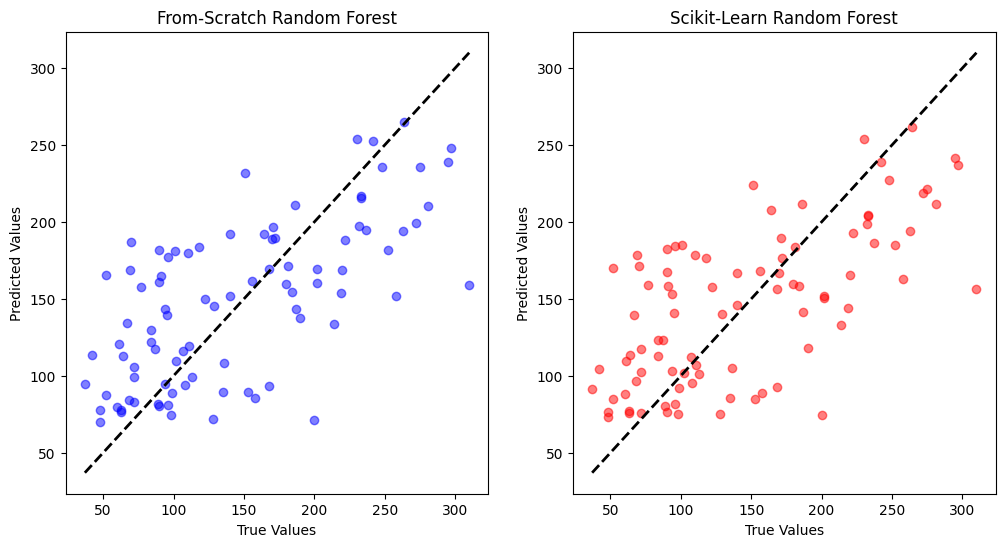

In [32]:
import matplotlib.pyplot as plt

# Predictions for the from-scratch model
y_pred_scratch = best_model.predict(X_test)

# Scatter plots
plt.figure(figsize=(12, 6))

# From-scratch implementation
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_scratch, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("From-Scratch Random Forest")

# Scikit-learn implementation
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_sklearn, color='red', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Scikit-Learn Random Forest")

plt.show()
